Import some prerequisites

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math

Run this cell for plotting

In [2]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''

    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

Run this cell for change polar to cartesian.

In [3]:
def pol_to_car(rho, theta):
    '''
    Changes rho and theta of a line to two point of that line.

    Parameters:
        rho (float): The distance from the origin to the line.
        theta (float):  Angle from origin to the line.

    Returns:
        (tuple): tuple of two point of line.
    '''

    a = np.cos(theta)
    b = np.sin(theta)
    c = 1000
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + c * (-b))
    y1 = int(y0 + c * (a))
    x2 = int(x0 - c * (-b))
    y2 = int(y0 - c * (a))
    return x1, y1, x2, y2

Implement this function to detect and remove circles in the given image.

In [4]:
def remove_circles(image):
    '''
    Returns the image which circles have been removed.

    Parameters:
        image (numpy.ndarray): The input image.

    Returns:
        out_img (numpy.ndarray): The result image.
    '''
    out_img = image.copy()

    #Writer your code here

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=50, param2=30, minRadius=0, maxRadius=40)

    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
      cv2.circle(out_img, (x, y), r+3, (0, 0, 0), -1)

    return out_img


Test your implementation (dont change this cell)

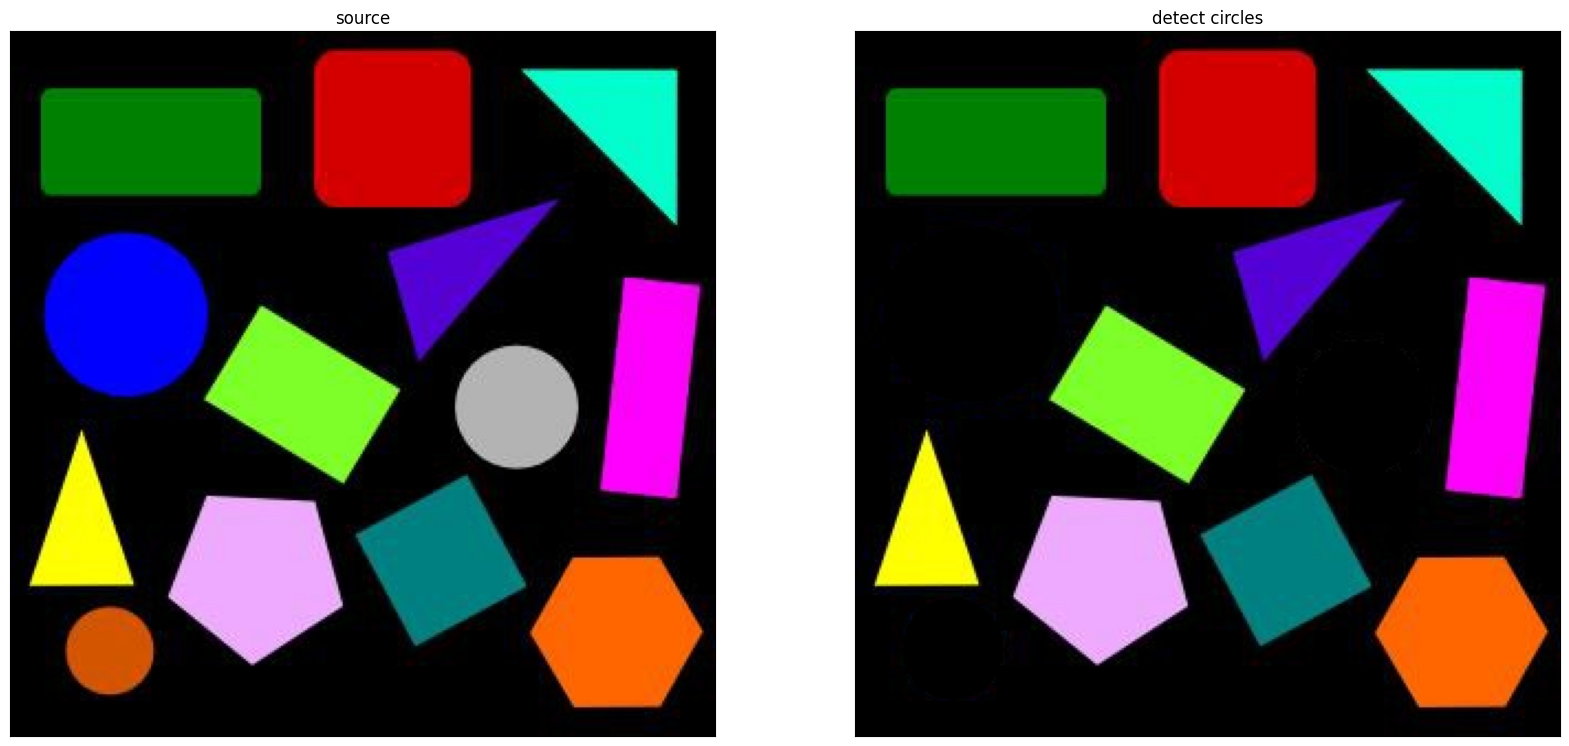

In [7]:
image_list = []

image = cv2.imread(os.path.join('1.jpg'))
image_list.append([cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'source', 'img'])

out_img = remove_circles(image)

image_list.append([cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB), 'detect circles', 'img'])

plotter(image_list, 1, 2, True, 20, 10, 'q4a')

Implement this function to detect lines in the given image with hough algorithm.

In [8]:
def detect_lines_hough(image):
    '''
    Returns the image which lines have been detected.

    Parameters:
        image (numpy.ndarray): The input image.

    Returns:
        out_img (numpy.ndarray): The result image.
    '''
    out_img1 = image.copy()
    out_img2 = image.copy()

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 20, 100)
    lines = None
    lines1 = cv2.HoughLinesP(edges, 0.1, np.pi / 180, 1, lines)
    lines2 = cv2.HoughLines(edges, 1, np.pi / 180, 50)

    for line in lines1:
      x1, y1, x2, y2 = line[0]
      cv2.line(out_img1, (x1, y1), (x2, y2), (255, 255, 255), 2)

    for rho, theta in lines2[:, 0]:
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a * rho
      y0 = b * rho
      x1 = int(x0 + 200 * (-b))
      y1 = int(y0 + 200 * (a))
      x2 = int(x0 - 200 * (-b))
      y2 = int(y0 - 200 * (a))
      cv2.line(out_img2, (x1, y1), (x2, y2), (255, 255, 255), 2)

    return out_img1 , out_img2

Test your implementation (dont change this cell)

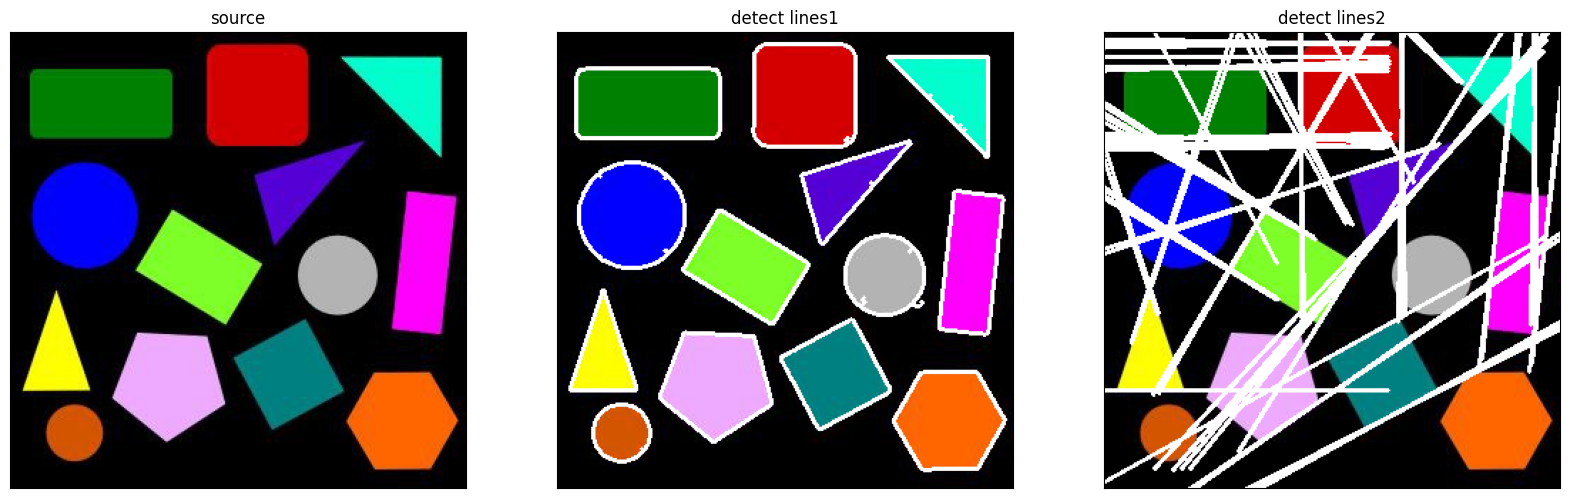

In [11]:
image_list = []

image = cv2.imread('1.jpg')
image_list.append([cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'source', 'img'])

out_img1 , out_img2 = detect_lines_hough(image)

image_list.append([cv2.cvtColor(out_img1, cv2.COLOR_BGR2RGB), 'detect lines1', 'img'])
image_list.append([cv2.cvtColor(out_img2, cv2.COLOR_BGR2RGB), 'detect lines2', 'img'])

plotter(image_list, 1, 3, True, 20, 10, 'q4b')

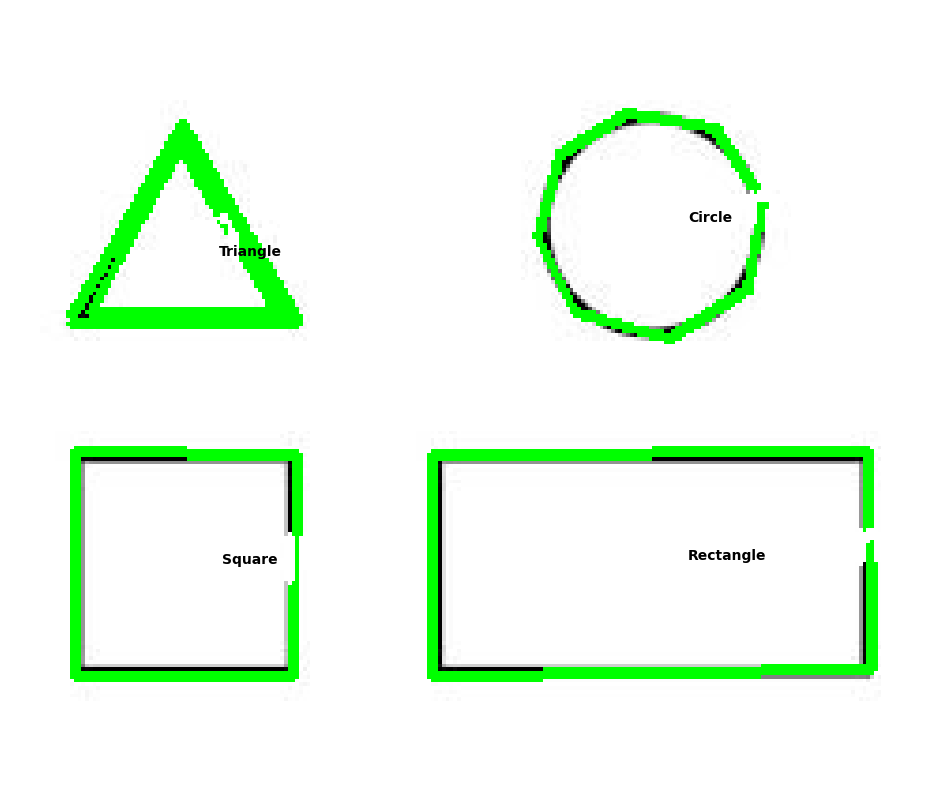

In [12]:
def detect_shape(image_path):
    # Read the input image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Failed to load the image.")
        return

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply edge detection using Canny
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the image
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate over the contours
    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Calculate the number of vertices
        num_vertices = len(approx)

        # Determine the shape based on the number of vertices
        shape = None
        if num_vertices == 3:
            shape = "Triangle"
        elif num_vertices == 4:
            # Check if the contour is a square or rectangle
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            shape = "Square" if aspect_ratio >= 0.95 and aspect_ratio <= 1.05 else "Rectangle"
        else:
            # Check if the contour is approximately a circle
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            circularity = 4 * np.pi * area / (perimeter * perimeter)
            if circularity > 0.85:
                shape = "Circle"

        # Draw the contour on the image
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)

        # Find the centroid of the contour
        M = cv2.moments(approx)
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])

        # Display the shape name next to the contour
        cv2.putText(image, shape, (cx + 10, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Convert BGR image to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the result as a plot
    plt.imshow(image_rgb)

    # Annotate the plot with shape names
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        M = cv2.moments(approx)
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])

        num_vertices = len(approx)
        shape = None
        if num_vertices == 3:
            shape = "Triangle"
        elif num_vertices == 4:
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            shape = "Square" if aspect_ratio >= 0.95 and aspect_ratio <= 1.05 else "Rectangle"
        else:
            # Check if the contour is approximately a circle
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            circularity = 4 * np.pi * area / (perimeter * perimeter)
            if circularity > 0.85:
                shape = "Circle"

        plt.text(cx + 10, cy, shape, color='black', fontsize=10, fontweight='bold')

    plt.axis('off')
    plt.show()

# Path to the input image
image_path = "7.jpg"

# Detect and label shapes in the input image
detect_shape(image_path)